In [1]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import xtrack as xt
import xobjects as xo
import xpart as xp

import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm








beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006


I=2.4
L = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 0.01 # <E> [eV] = kb*T
T_l =  0.001 # <E> [eV]
B = 0.060 # T for AD
B_ratio=1e-10
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



length = 182.43280000000 #m
T = length/(c*beta_rel)
ms_per_turn = 1000*T







In [2]:
cooling_time=[]

beta_values = np.linspace(2, 80, num=20)

for beta in tqdm(beta_values):

    beta_x=beta 
    beta_y=4
    emittance=10*1e-6

    arc=dtk.LinearTransferMatrix(Q_x=5.38518956965, Q_y=5.36921653748,
                                beta_x_0=beta_x, beta_x_1=beta_x,
                                beta_y_0=beta_y,  beta_y_1=beta_y,
                                alpha_x_0=0,   alpha_x_1=0,
                                alpha_y_0=0,   alpha_y_1=0,
                                disp_x_0=0,disp_x_1=0,
                                disp_y_0=0,    disp_y_1=0,
                                beta_s=1*1e40,
                                Q_s=0,
                                chroma_x=0.0, chroma_y=0
                                            
                    )


    num_particles=1
    emitt_x=10*1e-6 #inital emittance

    x_init=np.sqrt(2*beta_x*emitt_x)

    dtk_particle = dtk.TestParticles(
            
            mass0=mass0,
            p0c=p0c,
            x=x_init,
            px=0,
            y=0,
            py=0,
            delta=0,
            zeta=0)

    dtk_particle_copy_old=dtk_particle.copy()


    dtk_cooler = dtk.elements.ElectronCooler(I=I,L=L,r_beam=r_beam,
                                            T_perp=T_perp,T_l=T_l,
                                            B=B,Z=Z,B_ratio=0)

        


    num_turns=int(5*1e7)
    step=1000

    # initialize arrays
    x = []
    px = []
    action_x = []



    # calculate initial action value
    initial_action_x = emitt_x

    # calculate 90% of initial action value
    target_action_x = initial_action_x * 0.1

    # initialize a flag variable to keep track of whether the condition has been met
    condition_met = False

    # loop through the turns
    for i in tqdm(range(num_turns)):
        if i % step == 0:
            x.append(dtk_particle.x)
            px.append(dtk_particle.px)

            # calculate action in horizontal plane
            action_x_temp = 0.5*(dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2)
            action_x.append(action_x_temp)

            # check if the action has decreased by 90%
            if action_x_temp <= target_action_x:
                condition_met = True
                cooling_time.append(i * ms_per_turn)
                break
                    


        arc.track(dtk_particle)
        dtk_cooler.track(dtk_particle)

    if not condition_met:
        cooling_time.append(1e6)            

    # convert arrays to numpy arrays
    x = np.array(x)
    px = np.array(px)
    action_x = np.array(action_x)




    time = np.arange(0, num_turns, step) * ms_per_turn



100%|██████████| 20/20 [14:36<00:00, 43.84s/it]


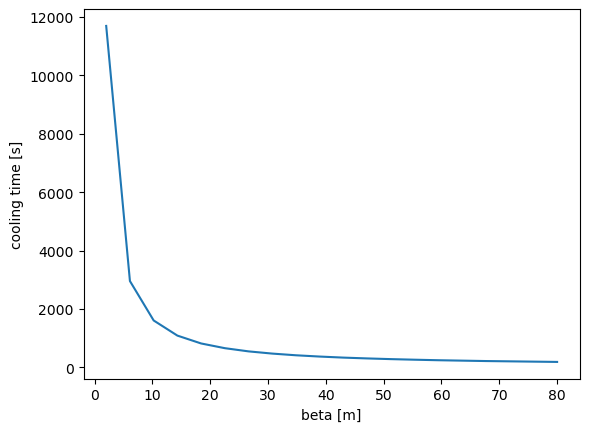

In [4]:
plt.figure()
plt.plot(beta_values,cooling_time)
plt.xlabel('beta [m]')
plt.ylabel('cooling time [s]')
plt.show()